In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

# Kalman Filter Constant Velocity Model (CV)


An autonomous vehicle drives through a tunnel and losses the GPS signal. Vehicle has to infer, where it is in the tunnel. The only information that the vehicle has available to it is the velocity (revolutions of the wheels). The velocity components along the $x$ and $y$ axes (i.e. $\dot x$ and $\dot y$) can be calculated by using the absolute velocity and the heading direction of the vehicle (yaw rate sensor).

## State Vector

(Constant velocity) **Motion equations**:

$$x_{k+1} = \textbf{A} \cdot x_{k}$$

where

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x_k \\ y_k \\ \dot x_k \\ \dot y_k \end{bmatrix} + \epsilon_k$$

**Measurement Model**:

$$z_k = \textbf{C} \cdot x_k$$

$$z_k = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix} \cdot x_k + \delta_k$$ 


### Initial State $x_0$

$$x_{0} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$

In [118]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)


### Initial Uncertainty $P_0$

In [119]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


### State transition and measurement matrices:

In [120]:
dt = 0.1 # Time Step

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

C = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(C, C.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


### Measurement Noise Covariance $Q$

This is an indication of sensors accuracy:

$$Q = \begin{bmatrix}\sigma^2_{\dot x} & 0 \\ 0 & \sigma^2_{\dot y} \end{bmatrix}$$

In [121]:
qa = 10.0**2

Q = np.matrix([[qa, 0.0],
              [0.0, qa]])
print(Q, Q.shape)

[[100.   0.]
 [  0. 100.]] (2, 2)


### Process Noise Covariance $R$

The Position of the car can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). Process noise covariance matrix Q.

$$R = \begin{bmatrix}
    \sigma_{x}^2 & 0 & \sigma_{x \dot x} & 0 \\
    0 & \sigma_{y}^2 & 0 & \sigma_{y \dot y} \\
    \sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2 
   \end{bmatrix}$$




In [122]:

R = np.matrix([[(dt**4)/4, 0, (dt**4)/2, 0],
               [0, (dt**4)/4, 0, (dt**4)/2],
               [(dt**4)/2, 0, dt**2, 0],
               [0, (dt**4)/2, 0, dt**2]]) * 1
print(R)

[[2.5e-05 0.0e+00 5.0e-05 0.0e+00]
 [0.0e+00 2.5e-05 0.0e+00 5.0e-05]
 [5.0e-05 0.0e+00 1.0e-02 0.0e+00]
 [0.0e+00 5.0e-05 0.0e+00 1.0e-02]]


### Identity Matrix $I$

In [123]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


## Measurements

As an example synthetic data will be used.

In [124]:
m = 200 # Number of measurements
vx= 20 # true velocity in x direction
vy= 10 # true velocity in y direction

mx = np.array(vx+np.random.normal(0,0.1,m)) #sensor measurement
my = np.array(vy+np.random.normal(0,0.5,m))   #sensor measurement

measurements = np.vstack((mx,my)) #stacking measurements

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % Q[0,0])

(2, 200)
Standard Deviation of Acceleration Measurements=0.10
You assumed 100.00 in R.


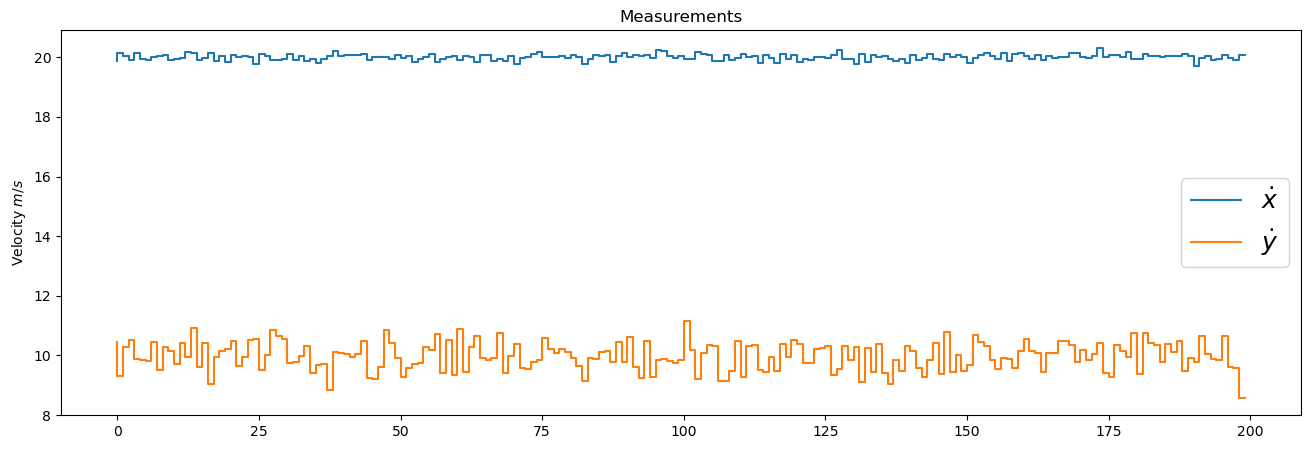

In [125]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [126]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

# Kalman Filter

In [127]:
for n in range(measurements.shape[1]):
    # 1. bel_hat(x_t)
    # Time Update (Prediction)
    # ========================
    # Predict the state
    x = A*x
    
    # Predict the error covariance 
    P = A*P*A.T + R
    
    
    # 2. bel(x_t)
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = C*P*C.T + Q
    K = (P*C.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (C*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*C))*P
    
    # Save states (for Plotting)
    savestates(x, Z, P, K)

### Kalman Gain $K$

In [136]:
def plot_K():
    fig = plt.figure(figsize=(10,5))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain')
    plt.legend(loc='best',prop={'size':22})
    plt.grid()

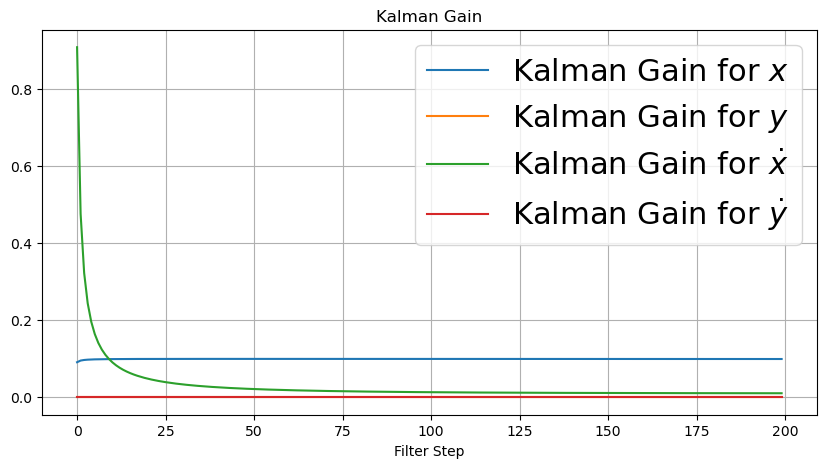

In [137]:
plot_K()

### Uncertainty Matrix $P$

In [138]:
def plot_P():
    fig = plt.figure(figsize=(10,5))
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
    plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})
    plt.grid()

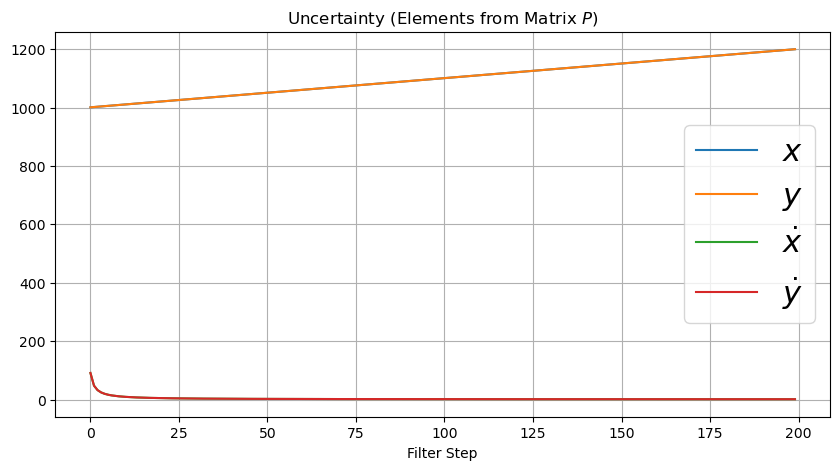

In [139]:
plot_P()

### State Estimate $x$

In [140]:
def plot_x():
    fig = plt.figure(figsize=(15,5))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    #plt.ylim([0, 30])
    plt.ylabel('Velocity')

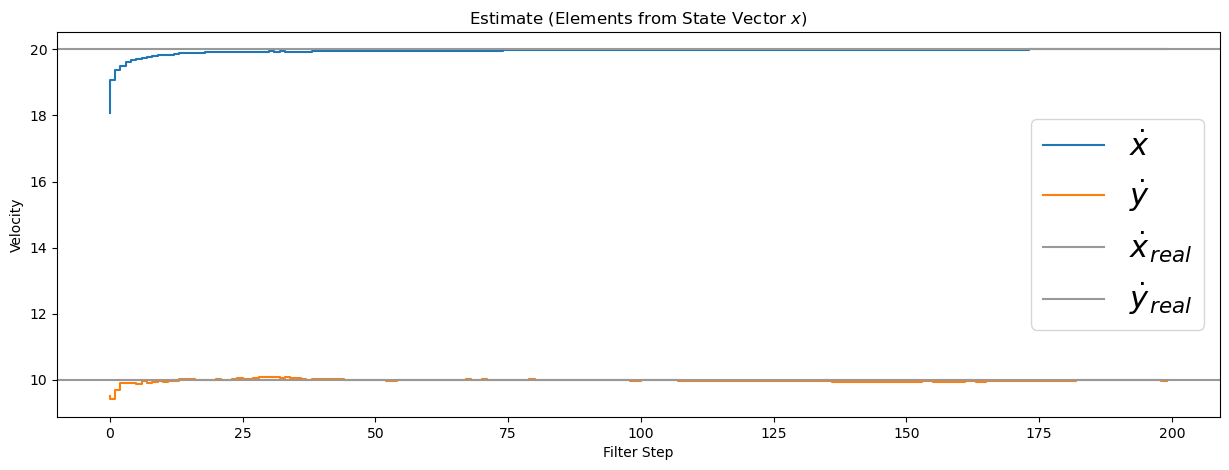

In [141]:
plot_x()

## Position x/y

In [142]:
def plot_xy():
    fig = plt.figure(figsize=(15,5))
    plt.scatter(xt,yt, s=20, label='State', c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')

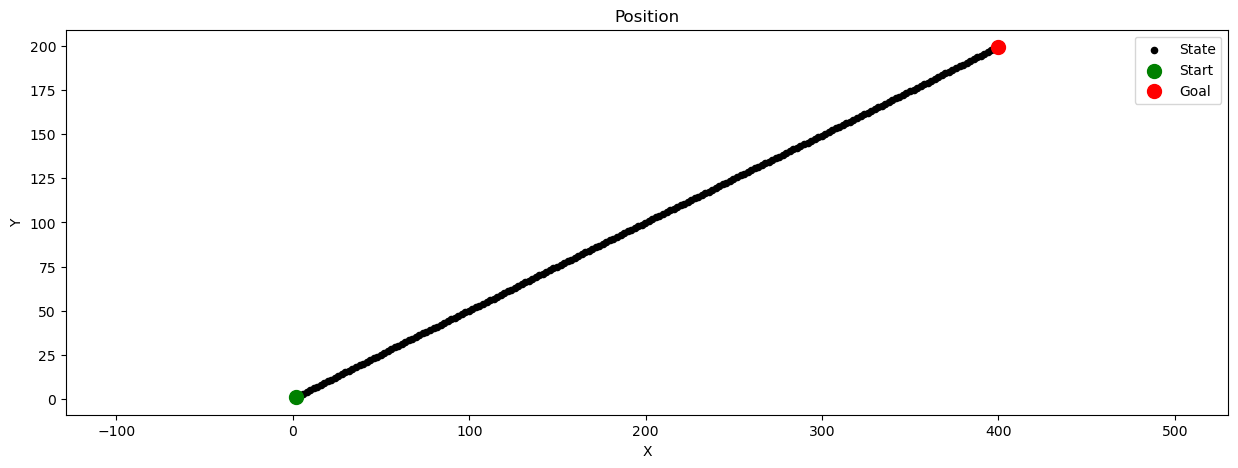

In [143]:
plot_xy()

In [ ]:
#Number of particles
M=1000
#Initial state and uncertainty
x = np.array([0.0, 0.0, 0.0, 0.0])
P = np.diag([10.0, 10.0, 10.0, 10.0])
#Simulate set of particles from bel(x_0)
x_particles=np.random.multivariate_normal(mean=x,cov=P,size=M).T

t1=[]
t2=[]
t3=[]
t4=[]


for n in tqdm(range(len(measurements[0]))):
    #Apply state transition equations
    x_particles=A*x_particles
    #Then contaminate states by noise
    for m in range(M):
        miu=np.asarray(x_particles[:,m]).reshape(-1)
        m_particle=np.random.multivariate_normal(mean=miu,cov=R*100,size=1).T
        x_particles[:,m]=m_particle
    
    z_particles=C*x_particles
    #The following line of code is a weird manifestation of Pythons' inadequacies.
    #Without this another line of code does not work :D I don't know why. If you come up with more gracefull solution - tell me.
    measurement_tiled=np.tile(np.reshape(measurements[:,n],(2,1)),M)
    
    #Here we calculate weights and then normalize them, so that the sum is 1.
    w=np.exp(-0.5/1*np.diag((measurement_tiled-z_particles).T*np.linalg.inv(Q)*(measurement_tiled-z_particles)))
    w=w/np.sum(w)
    #Systematic resampling is performed
    resample_idx=np.random.choice(range(M), M, p=np.asarray(w).reshape(-1))
    x_particles=x_particles[:,resample_idx]
    
    #collecting mean values of particles for each state
    t1.append(np.mean(x_particles[0,:]))
    t2.append(np.mean(x_particles[1,:]))
    t3.append(np.mean(x_particles[2,:]))
    t4.append(np.mean(x_particles[3,:]))


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]


(-39.80152821151323,
 842.0952118660325,
 -19.816370519079225,
 419.00954378684446)

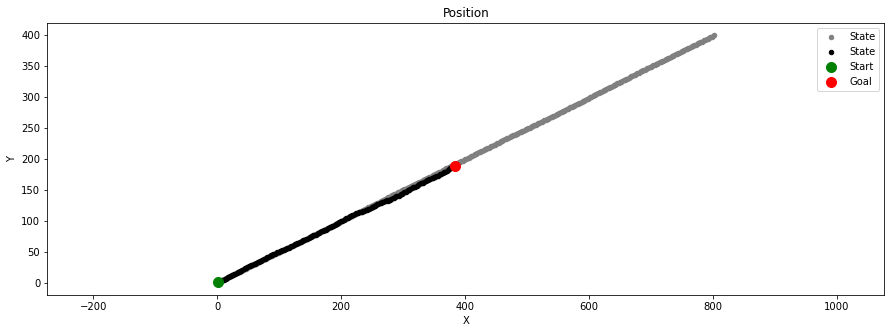

In [ ]:
   
fig = plt.figure(figsize=(15,5))
plt.scatter(xt,yt, s=20, label='State', c='grey')
plt.scatter(t1,t2, s=20, label='State', c='k')
plt.scatter(t1[0],t2[0], s=100, label='Start', c='g')
plt.scatter(t1[-1],t2[-1], s=100, label='Goal', c='r')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

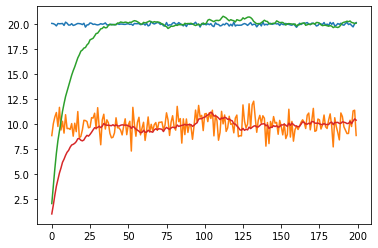

In [23]:

plt.plot(measurements[0,:].T)
plt.plot(measurements[1,:].T)
plt.plot(t3)
plt.plot(t4)